# Web Crawler

Collect text data from the PTT forum, process the article texts, and finally create a word cloud for a quick overview of the topics in these collected texts.

## Crawling Data from PTT

In [1]:
import requests
from bs4 import BeautifulSoup as soup  # HTML data structure
from lxml import etree


# extract article hyperlinks from an index page
def extractArtLinks(url):
    r = requests.get(url, cookies={'over18': '1'})
    page_soup = soup(r.text, "html.parser")
    containers = page_soup.findAll("div", {"class": "r-ent"})
    art_links = []
    for container in containers:
        # Finds all link tags "a" from within the first div.
        art_link = container.find('a')
        if art_link:
            #print(art_link['href'])
            #print(container.find('div',{'class':'title'}).get_text())
            art_meta = container.find('div', {'class': 'meta'})
            #print(art_meta.find('div',{'class':'author'}).get_text())
            #print(art_meta.find('div',{'class':'date'}).get_text())

            art_links.append({
                'push':
                container.find('div', {
                    'class': 'nrec'
                }).get_text(),
                'title':
                container.find('div', {
                    'class': 'title'
                }).get_text().strip(),
                'date':
                art_meta.find('div', {
                    'class': 'date'
                }).get_text(),
                'author':
                art_meta.find('div', {
                    'class': 'author'
                }).get_text(),
                'link':
                art_link['href'],
                'text':
                extractArtText('https://www.ptt.cc' + art_link['href'])
            })

    return (art_links)


# find the previous index page link
def findPrevIndex(url):
    r = requests.get(url, cookies={'over18': '1'})
    page_soup = soup(r.text, "html.parser")
    btn = page_soup.select('div.btn-group > a')
    up_page_href = btn[3]['href']
    next_page_url = 'https://www.ptt.cc' + up_page_href
    return (next_page_url)


# extract article contents from  the article hyperlink
def extractArtText(url):
    r = requests.get(url, cookies={'over18': '1'})
    #page_soup = soup(r.text, "lxml")
    #print(page_soup.find("div",{"id":"main-content"}).get_text())
    #art_text=page_soup.select('div#main-content', limit=1)[0].text
    content = r.content.decode()
    html = etree.HTML(content)
    art_text = html.xpath(
        "//div[@id='main-content']/text()[not(self::div|self::span[@class='f2'])]"
    )
    return ''.join(list(art_text))

In [2]:
## Debug Use

# url = 'https://www.ptt.cc/bbs/Food/M.1602332821.A.6F3.html'
# r = requests.get(url, cookies={'over18': '1'})
# #page_soup = soup(r.text, "lxml")
# #print(page_soup.find("div",{"id":"main-content"}).get_text())
# #art_text=page_soup.select('div#main-content', limit=1)[0].text
# content = r.content.decode()
# html = etree.HTML(content)
# art_text = html.xpath(
#     "//div[@id='main-content']/text()[not(self::div|self::span[@class='f2'])]")

# print(''.join(list(art_text)))

```{note}
For CSS selector, don't know how to set conditional criteria to select only texts under div#main-container but not those included in the child div.article-metaline and span.f2.

So here I use the XPath, which requires the lxml package.
```

In [3]:
# main()
num_of_index_page = 5
board_name = 'Food'
url = 'https://www.ptt.cc/bbs/{}/index.html'.format(board_name)
all_links = []
for page in range(1, num_of_index_page):
    all_links = all_links + extractArtLinks(url)
    url = findPrevIndex(url)
len(all_links)

83

In [4]:
type(all_links[2])
print(all_links[2])

{'push': '', 'title': '[食記] 新北 中港蚵仔麵線臭豆腐', 'date': '11/05', 'author': 'leafphoto', 'link': '/bbs/Food/M.1604571617.A.97F.html', 'text': '\n  餐廳名稱：中港蚵仔麵線臭豆腐\n  電話：02 2277 6918\n  營業時間：06:00–21:00\n  地址：新北市新莊區中港路343號\n  無音樂。有圖真相網誌版：\n  消費時間：2020.10\n  每人平均價位：70\n  可否刷卡：不可\n  有無包廂：無\n  推薦菜色：蚵仔麵線\n  官網：略\n\n =====我是分隔線======\n這天跟朋友約來新莊，趁著天氣還不錯就順便四處尋訪新莊小吃，\n很不巧原本想去的名單偏偏一間已歇業，一間公休，早餐沒吃的我早就餓歪，\n最後發現『中港蚵仔麵線臭豆腐』在不遠處，說起來奇妙，『中港麵線』是在某次介紹林\n口全興大腸蚵仔麵線時，林口人推薦我的私房名單。\n『中港蚵仔麵線臭豆腐』從早賣到晚，在新莊已屬小有名氣在地老店，許多喜歡台式早餐\n的，早上就愛這味！\n\n『中港蚵仔麵線臭豆腐』店面就一般傳統小吃店的感覺，不過天熱時除非客人多，不然只\n開風扇內用真比較熱些。\n\n『中港蚵仔麵線臭豆腐』菜單價目表 (2020.10)\n除了炸臭豆腐、蚵仔麵線之外，也有甜不辣、腸旺鴨血臭豆腐，甚至泡菜也有單賣。\n不過多數人還是推薦麵線跟臭豆腐。\n\n原本跟朋友要四處多找找新莊小吃，不過第一攤我就餓歪了，等老闆餐點一上桌馬上開吃\n！\n\n『中港蚵仔麵線臭豆腐』- 蚵仔麵線\n說是蚵仔麵線，但其實配料還是以大腸為主，蚵仔看得到但並不算多，也不大顆。\n許多新莊人介紹這裡最大特色是大腸、蚵仔超多，不過這天配料上我覺得還好，\n雖然用料也並不少，但也說不上超多，\n蚵仔看得出裹粉，而大腸切為小段，滷色不深，且看得出腸內留有油脂，\n湯頭方面屬柴魚湯底，整體來說算是中規中矩，不錯吃但也說不上驚艷。\n\n『中港蚵仔麵線臭豆腐』- 臭豆腐\n這邊的臭豆腐比較偏向北部做法，不是中南部炸澎挖洞那種，\n切成小塊後酥炸，偏向乾酥的類型，脆口但不過硬，\n搭配隨附的泡菜吃起來清爽，整體來說挺好吃的！\n\n後記：\n『中港麵線』靠近新莊體育場，

In [5]:
print('Push: {push:s} \n'
      'title: {title:s} \n'
      'date: {date:s} \n'
      'author: {author:s} \n'
      'link: {link:s} \n'
      'text: {text:.20} \n'.format(**all_links[3]))

Push:  
title: [抱怨] 許仔豬腳麵線 
date: 11/05 
author: jamiro0000 
link: /bbs/Food/M.1604572704.A.F11.html 
text: 

  餐廳名稱：許仔豬腳麵線

  地 



## Text Normalization

In [6]:
import sys
sys.path.insert(1, '../nlp')
import text_normalizer_zh as tn

In [7]:
print(all_links[3]['text'])



  餐廳名稱：許仔豬腳麵線

  地址：台北市大同區保安街49巷17號
  電話：0952005739
  消費時間：2020年/10月
  事發經過：

想了一下決定還是來抱怨一下
這家許仔豬腳麵線滿有名的，當天去的時候
人潮也很多，需要排隊

先說，對於味道真的沒甚麼好抱怨的
豬腳分量多，軟嫩好吃
但是想抱怨的點在於他們家的衛生= =

因為我是坐攤位前面的位子，所以在等待餐點的時候
就眼睜睜的看到應該是許仔的老闆
徒手拿豬腳之後，又拿客人的錢找零
中間完全沒洗手，也沒有說換一隻手拿
其他員工也是一樣，阿姨一邊剁著肉
也是很自然地接下客人的錢再去找零

看了實在滿不舒服的= =
可以理解人多，所以可能沒辦法那麼周全
但是也許可以再多雇一個人，專門找零
或是戴個手套，拿錢的時候脫下來之類的都可以
我想都會衛生很多，畢竟零錢、紙鈔應該很髒
找完錢又用手直接拿著等等要吃的豬腳...

餐點好吃是沒錯，但這點我真的沒辦法
尤其坐前面又看得特別清楚
不知道有沒有人注意過
大家之後去吃的話可以稍微注意看看
除非有改，不然我應該是不會再回訪了

--



In [8]:
raw = [art['text'] for art in all_links if len(art) != 0 and len is not None]
raw_normalized = tn.normalize_corpus(raw)

Building prefix dict from /Users/Alvin/GoogleDrive/_MySyncDrive/RepositoryData/data/jiaba/dict.txt.jiebatw.txt ...


Loading model from cache /var/folders/n7/ltpzwx813c599nfxfb94s_640000gn/T/jieba.u1b52b47246a0f2e6497af6bbe107adac.cache


Loading model cost 0.605 seconds.


Prefix dict has been built successfully.


In [9]:
import pandas as pd

corpus_df = pd.DataFrame({"raw": raw, "normalized": raw_normalized})

In [10]:
corpus_df.head(2)

,raw,normalized
0,\n\n 餐廳名稱：蘭花亭\n 消費時間：2020年11月\n 地址：台北市中正...,餐廳 名稱 蘭花 亭 消費 時間 年 月 地址 台北市 中正區 廈門街 號 電話 營業 時間...
1,\n 餐廳名稱：El mundo墨多墨西哥料理\n 消費時間：2020年/10月\n...,餐廳 名稱 墨多 墨西哥 料理 消費 時間 年 月 例 年 月 未 提供 則 文章 不予 保...


In [11]:
raw[5]

'\n\n\n\n圖文網誌建議閱讀版：\n\n\n\n【Mercato Pizza-漁市場】\n\n地址︰880澎湖縣馬公市北辰街10號\n\n電話︰06-9266098，淡季可訂位\n\n營業時間：17:00-21:00\n\n休日&活動：請參店家臉書\n\n#不收服務費 #現金結帳\n\n\n\n\n沒想到在馬公市區上會有著這麼一家義國料理！\n\n當初在IG發現覺得太美便被我立刻放進拜訪清單\n\n飛機落地發個限動，就被公司裡懂吃的澎湖姐姐大力推薦之餐廳\n\n如果你對前身名店的【漁市場炸物】有些熟悉\n\n那麼肯定要來會一會這進化版本的【Mercato Pizza】阿！\n\n用餐日期：2020/10\n\n\n\n被食物控制的一群人為了不能訂位的這頓晚餐\n\n我們風風火火的放棄夕陽從漁翁島殺回馬公市區\n\n幸好下午五點抵達時還有很多座位\n\n(開車可以停在附近郵局旁的收費停車場)\n\n最吸人眼球的便是大面玻璃窗前的窯烤火爐了\n\n\n\n穿過櫃台，1樓和2樓的用餐區域完全無法和披薩店連結\n\n也、太、美、了。\n\n白牆木椅和透明壓克力，還有夢幻的磨石子地板\n\n明明就是韓國歐膩的咖啡館阿哈哈\n\n\n\n就連手繪菜單也做得好可愛，拿起menu像是打開畫本\n\n我們7個人選了一套『四人分享餐』$1550\n\n單點『瑪格麗特披薩』$240、『漁市場招牌薯條』$80\n\n還有『泡泡仙人掌』$120等兩杯飲料\n\n吃巧但沒有完全吃飽的份量，把剩下的胃留給炭烤剛好XD\n\n\n\n餐點採現點現做，所以下樓點餐的同時還能看見櫃台內正在忙活的職員們\n\n原來雲朵披薩是這個樣子滾出來的，好有趣！\n\n\n\n最先上桌的是『季節沙拉』$150、『泡泡仙人掌』$120\n\n裡頭有美生菜、玉米、小番茄、葡萄和鷹嘴豆\n\n喜歡那杯紅色的泡泡仙人掌 (自製仙人掌果醬mix汽水)\n\n\n\n被眾人稱讚到不行的『焦糖海鹽薯條』$120\n\n堅果碎片讓熟悉的脆薯有了不一樣的口感\n\n搭配不太甜的焦糖醬又迸出新滋味，Bravo！\n\n\n\n『瑪格麗特披薩』$240\n\n完全得靠食材品質與麵糰來直球對決的經典款口味\n\n選用了義大利番茄泥/帕達諾乾酪/莫扎瑞拉起司/初榨橄欖油/羅勒葉\n\n有別於我們平常在台北喜歡吃的【好時光披薩】(os搭

In [12]:
raw_normalized[4]

'無 音樂 圖文 網誌 版 純 文字 版 台中 北區 金寶 茶 餐廳 館 前店 我 心 目中無人 能 替代 的 真愛 叉燒 酥 餐廳 名稱 金寶 茶 餐廳 館 前店 最近 造訪 地址 台中市 北區 館前路 號 電話 營業 時間 用餐 時間 分鐘 有無 包廂 無 免費 無 可否 訂位 可 電話 訂位 假日 現場 候位 有無 低消 有 每人 一杯 飲料 人均 消費 可 刷卡 無 服務費 想 寫 金寶 想 很 久 了 但 因為 朋友 曾 說 他們 家 餐點 品質 落差 很 大 時好時壞 因此 遲遲 沒有 整理 但 目前 以 台中 來 說 只要 每次 我 想要 吃 港式 飲茶 第一個 總 想到 的 還是 金寶 茶 餐廳 如果 大家 有 知道 不錯 的 港點 口袋 名單 也 可以 分享 一下 其實 個 人 的 飲食 習慣 蠻 固定 的 到 餐廳 也 總是 點那 幾樣 東西 無法 當 皇帝 一樣菜 不能 夾 超過 次 以下 就 介紹 我 的 心頭 愛 菜色 相信 沒人會 無聊 到 在 我 的 食物 裡投毒 照例 先看 菜單 金寶 茶 餐廳 的 價位 來 說 我 覺得 是 可 接受 的 有 一次 心血來潮 想 去 百貨公司 的 茶樓 用餐 一 看到 價格 立馬 腳底 抹油 沒品 然後 跟 大家 介紹 一下 凍美祿 恐龍 就是 冰美祿 上面 再灑 一層 美祿 可可粉 啦 通常 第一道 一定 會點 的 就是 我 的 真愛 叉燒 酥 這道 通常 也 是 父母 常常 拿來 哄 小孩 的 菜色 看 那 油亮 的 酥皮 上 灑滿 噴香 的 白 芝麻 這道 我 完全 可以 一個 人 嗑光 沒 問題 再來 鮮蝦 腸粉 也 是 一定 要 的 喜歡 它 鹹鹹 甜甜 略帶 一點 醋味 的 沾醬 對 我 來 說 腸粉 也 是 吃 不膩 的 菜餚 來到 茶 餐廳 怎麼 可以 不點 廣東 粥 皮蛋 瘦肉 粥 也 是 個 熱門 選項 說 到 廣東 粥 我 不得不 提起 一件 事 有次 我們 在 金寶 茶 餐廳 點了 一碗 窩 蛋 牛肉 粥 服務 人員 問我蛋 要生 的 熟 的 我個 人 是 很 愛吃 半熟 蛋 所以 說 要生 的 結果 牛肉 粥 端上來 他們 是 直接 把 生蛋 打 在 粥裡 我 本來 以為 會 是 半熟 蛋 的 狀態 只能 說 港人 真的 很 遵照 字面 上 的 意思 做 啊 下次 我 試試

- [Unicode List](https://en.wikipedia.org/wiki/List_of_Unicode_characters)
- [Unicode Categories](https://unicodebook.readthedocs.io/unicode.html)

In [13]:
text = raw[0]
text

'\n\n   餐廳名稱：蘭花亭\n   消費時間：2020年11月\n   地址：台北市中正區廈門街77-3號\n   電話：02-2365-4221\n   營業時間：10:00~19:30\n   每人平均價位：100元上下，沒有低消\n   可否刷卡：否\n   有無包廂：無\n   推薦菜色：喜歡香麻的可以點半湯擔擔麵\n   官網(粉絲團)：\n\n\n今天是特別騎機車過來，機車蠻好停的\n\n一來到就先在櫃台點餐，點完餐店員會送到位子上\n\n餐具也會一起附上很貼心\n\n這間店蠻特別的，有賣比利時啤酒，不過今天騎機車來…\n\n所以無法喝 Not today~~\n\n\n\n\n\n\n會來這裡是之前在FB上看到網友介紹這間店，特別來朝聖\n\n今天特別點了 半湯擔擔麵(65元) 和 紫菜蛋花湯(30元)\n\n不囉嗦直接上圖比較快\n\n\n\n\n\n\n\n\n\n\n\n\n麵很Q彈，吃得到肉末和油蔥\n\n油蔥很香脆，外面有些會炸的苦苦的，他們不會\n\n湯帶著香麻香鹹的口感，非常的開胃！\n\n我是一口接一口\n\n吃完接著開喝紫菜蛋花湯，擔擔麵的口味比較重，搭配紫菜蛋花湯很剛好\n\n這樣吃其實還蠻有飽足感的\n\n以台北市這樣的價位來說，我覺得很ok\n\n下次再來吃別的\n\n--\n'

In [14]:
import unicodedata

result = ''.join(ch for ch in text
                 if unicodedata.category(ch)[0] not in ['P', 'S'])
result

'\n\n   餐廳名稱蘭花亭\n   消費時間2020年11月\n   地址台北市中正區廈門街773號\n   電話0223654221\n   營業時間10001930\n   每人平均價位100元上下沒有低消\n   可否刷卡否\n   有無包廂無\n   推薦菜色喜歡香麻的可以點半湯擔擔麵\n   官網粉絲團\n\n\n今天是特別騎機車過來機車蠻好停的\n\n一來到就先在櫃台點餐點完餐店員會送到位子上\n\n餐具也會一起附上很貼心\n\n這間店蠻特別的有賣比利時啤酒不過今天騎機車來\n\n所以無法喝 Not today\n\n\n\n\n\n\n會來這裡是之前在FB上看到網友介紹這間店特別來朝聖\n\n今天特別點了 半湯擔擔麵65元 和 紫菜蛋花湯30元\n\n不囉嗦直接上圖比較快\n\n\n\n\n\n\n\n\n\n\n\n\n麵很Q彈吃得到肉末和油蔥\n\n油蔥很香脆外面有些會炸的苦苦的他們不會\n\n湯帶著香麻香鹹的口感非常的開胃\n\n我是一口接一口\n\n吃完接著開喝紫菜蛋花湯擔擔麵的口味比較重搭配紫菜蛋花湯很剛好\n\n這樣吃其實還蠻有飽足感的\n\n以台北市這樣的價位來說我覺得很ok\n\n下次再來吃別的\n\n\n'

## Word Cloud

In [15]:
from collections import Counter
import imageio
from nltk.tokenize import WhitespaceTokenizer
from wordcloud import WordCloud, ImageColorGenerator
from matplotlib import pyplot as plt

In [16]:
## Check font paths
## !fc-list :lang=zh

ws = WhitespaceTokenizer()

tokens = [ws.tokenize(text) for text in raw_normalized]

In [17]:
from collections import Counter

# corpus token freq
tokens_freq = Counter(sum(tokens, []))
sorted(tokens_freq.items(), key=lambda x: x[1], reverse=True)

# corpus token freq per document
tokens_freq_per_doc = [Counter(wt) for wt in tokens]

# corpus token docfreq
tokens_df = Counter()

# map(tokens_df.update, (tfpd.keys() for tfpd in tokens_freq_per_doc))

for tfpd in tokens_freq_per_doc:
    tokens_df.update(tfpd.keys())

print(tokens_df)

Counter({'的': 83, '時間': 82, '有': 80, '是': 77, '地址': 76, '在': 75, '餐廳': 74, '也': 74, '號': 73, '營業': 73, '電話': 72, '了': 72, '消費': 71, '都': 71, '很': 70, '就': 69, '名稱': 67, '吃': 67, '不': 65, '可以': 62, '我': 61, '年': 59, '月': 59, '會': 58, '來': 58, '人': 57, '圖文': 55, '好': 53, '價位': 52, '版': 52, '好吃': 52, '但': 50, '上': 49, '說': 49, '沒有': 48, '要': 48, '每人': 47, '不過': 47, '到': 46, '跟': 45, '味道': 45, '因為': 45, '平均': 44, '推薦': 44, '比較': 43, '就是': 43, '不錯': 43, '和': 42, '覺得': 42, '口感': 41, '再': 41, '菜單': 41, '又': 41, '元': 40, '無': 40, '想': 40, '喜歡': 39, '我們': 39, '小': 38, '一': 37, '網誌': 37, '去': 36, '真的': 36, '看': 36, '得': 36, '如果': 36, '讓': 36, '所以': 35, '這': 35, '還': 35, '用餐': 35, '多': 34, '價格': 34, '店家': 34, '還有': 34, '選擇': 34, '菜色': 33, '口味': 33, '以': 33, '他': 33, '沒': 33, '還是': 33, '大': 33, '有無': 32, '不會': 32, '才': 32, '包廂': 31, '雖然': 31, '吃起來': 31, '刷卡': 30, '特別': 30, '店': 30, '餐點': 30, '等': 30, '一點': 30, '與': 30, '時': 29, '感覺': 29, '個': 29, '可否': 28, '看到': 28, '搭配': 28, '有點': 28, '或': 28, '很

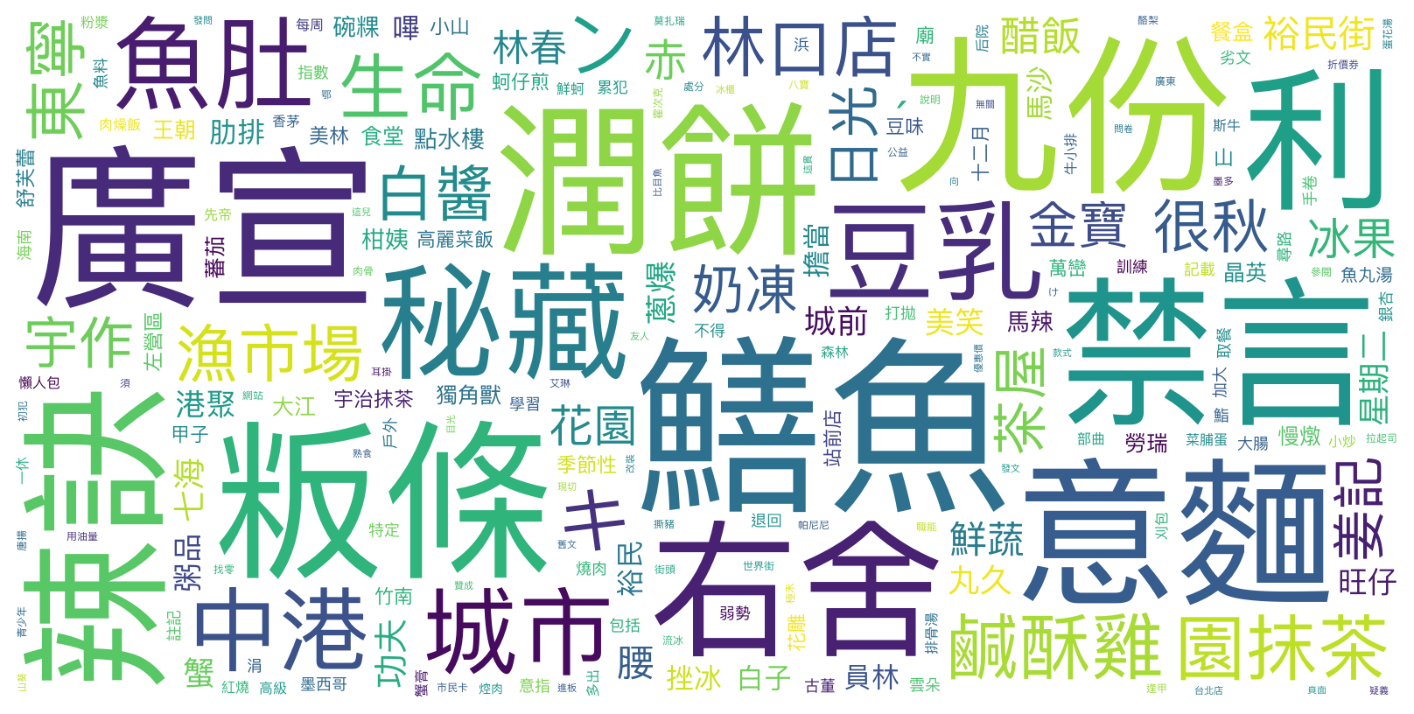

In [18]:
## Load stopwords
with open(
        '../../../RepositoryData/data/stopwords/tomlinNTUB-chinese-stopwords.txt'
) as f:
    stopwords = [w.strip() for w in f.readlines()]

# Create stopwords ad hoc
stopwords = set([
    '文章', '食記', '水桶', '刪除', '投票', '刪文', '連結', '板面', '板主', '規定', '違規', '使用',
    '所以', '禁止', '天', '票'
])

# Cutoff based on docfreq and stopwords
words2plot = dict([(w, tokens_freq[w]) for w, df in tokens_df.items()
                   if df < 2 and w not in stopwords and tokens_freq[w] >= 2])

wordcloud = WordCloud(font_path="/System/Library/Fonts/PingFang.ttc",
                      background_color='white',
                      stopwords=stopwords,
                      width=1600,
                      height=800,
                      margin=20)
# wordcloud.generate(' '.join([w for w in tokens_unnest if w not in stopwords]))
wordcloud.generate_from_frequencies(words2plot)
plt.figure(figsize=(20, 10), facecolor='w')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=1)
plt.show()
#plt.savefig('../data/twp-wordcloud2.png', facecolor='k', bbox_inches='tight')

:::{admonition} Exercise
How to seperate post texts from push texts?
:::
